<a href="https://colab.research.google.com/github/ikyath/M5-Forecasting-Accuracy-Kaggle/blob/master/M5Forecasting%26Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Abstract

Welcome to the "M5 Forecasting - Accuracy" competition! In this competition, contestants are challenged to forecast future sales at Walmart based on heirarchical sales in the states of California, Texas, and Wisconsin. Forecasting sales, revenue, and stock prices is a classic application of machine learning in economics, and it is important because it allows investors to make guided decisions based on forecasts made by algorithms

In [1]:
pwd

'/content'

In [2]:
cd /content/drive/My\ Drive/Data\ Science

/content/drive/My Drive/Data Science


In [3]:
import numpy as np
import pandas as pd
import joblib
from tqdm.notebook import tqdm as tqdm
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import gc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def read_data(PATH):
    print('Reading files...')
    calendar = pd.read_csv(f'{PATH}/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(f'{PATH}/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv(f'{PATH}/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv(f'{PATH}/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

In [6]:
calendar, selling_prices, sales, submission = read_data("/content/drive/My Drive/Data Science")

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [7]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [8]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


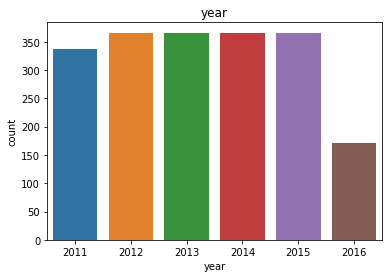

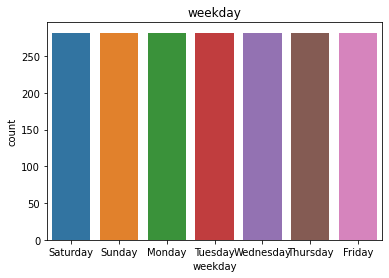

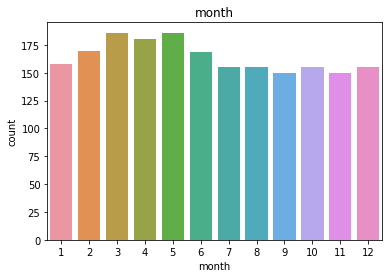

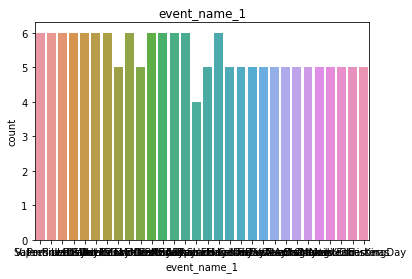

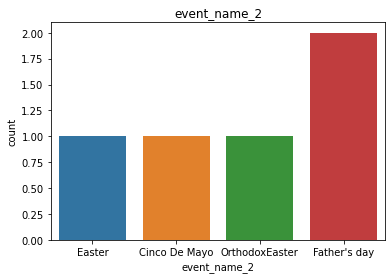

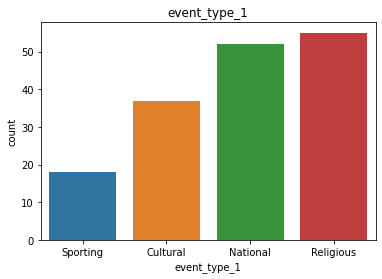

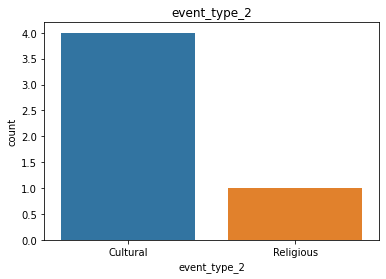

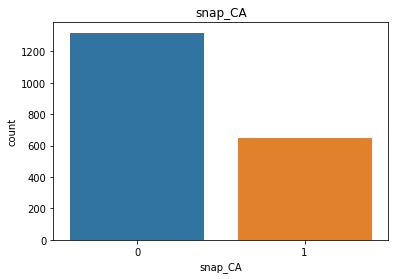

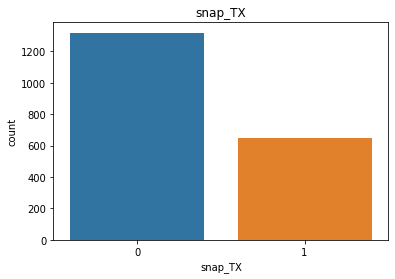

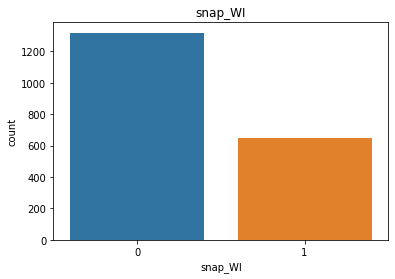

In [9]:
for i in ["year", "weekday", "month", "event_name_1", "event_name_2", "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"] :
  plt.figure()
  g=sns.countplot(calendar[i])
  g.set_title(i)

In [10]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [11]:
def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar)

Mem. usage decreased to  0.03 Mb (84.4% reduction)


In [12]:
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


In [15]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

selling_prices = prep_selling_prices(selling_prices)

Mem. usage decreased to 169.63 Mb (0.0% reduction)


In [16]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,CA_1,HOBBIES_1_001,11325,9.578125,NaN,NaN,0.0
1,CA_1,HOBBIES_1_001,11326,9.578125,0.000000,NaN,0.0
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.137695,NaN,0.0
3,CA_1,HOBBIES_1_001,11328,8.257812,0.000000,NaN,0.0
4,CA_1,HOBBIES_1_001,11329,8.257812,0.000000,NaN,0.0


In [17]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [0]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df


sales = reshape_sales(sales, 1000)

In [19]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1001,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1001,1.0


In [20]:
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())

    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
    df = reduce_mem_usage(df)

    return df

sales = prep_sales(sales)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mem. usage decreased to 1683.94 Mb (41.5% reduction)


In [21]:
sales.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
6311430,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582
6311431,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150
6311432,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027
6311433,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828
6311434,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527


In [22]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,11416,3,4,3,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,11416,3,4,3,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,11416,3,4,3,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,11416,3,4,3,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,11416,3,4,3,30,4,4,2,0,0,0


In [24]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,3,4,3,30,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,3,4,3,30,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,3,4,3,30,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,3,4,3,30,4,4,2,0,0,0,4.640625,0.0,0.0,0.231201
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,3,4,3,30,4,4,2,0,0,0,3.080078,0.0,0.0,0.375244


In [25]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 0 to 23233379
Data columns (total 30 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   item_id              object 
 2   dept_id              object 
 3   cat_id               object 
 4   store_id             object 
 5   state_id             object 
 6   d                    int16  
 7   demand               float16
 8   lag_t28              float16
 9   rolling_mean_t7      float16
 10  rolling_mean_t30     float16
 11  rolling_mean_t60     float16
 12  rolling_mean_t90     float16
 13  rolling_mean_t180    float16
 14  rolling_std_t7       float16
 15  rolling_std_t30      float16
 16  wday                 int8   
 17  month                int8   
 18  year                 int8   
 19  event_name_1         int8   
 20  event_type_1         int8   
 21  event_name_2         int8   
 22  event_type_2         int8   
 23  snap_CA              int8   
 

In [26]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)

gc.collect()


Mem. usage decreased to 1329.42 Mb (36.2% reduction)


6

In [27]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,3,4,3,30,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,3,4,3,30,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,3,4,3,30,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,3,4,3,30,4,4,2,0,0,0,4.640625,0.0,0.0,0.231201
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,3,4,3,30,4,4,2,0,0,0,3.080078,0.0,0.0,0.375244


In [28]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
            "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())

    


In [29]:
    sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582,3,4,3,30,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150,3,4,3,30,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027,3,4,3,30,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828,3,4,3,30,4,4,2,0,0,0,4.640625,0.0,0.0,0.231201
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527,3,4,3,30,4,4,2,0,0,0,3.080078,0.0,0.0,0.375244


In [30]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

gc.collect()

34

In [33]:
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel,F
21525940,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1914,NaN,1.0,1.142578,1.033203,0.983398,0.944336,0.772461,0.689941,0.927734,2,3,5,30,4,4,2,0,0,0,8.382812,0.0,0.066833,0.053864,F1
21525941,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1914,NaN,1.0,0.714355,0.333252,0.250000,0.211060,0.377686,0.488037,0.479492,2,3,5,30,4,4,2,0,0,0,3.970703,0.0,0.000000,0.000000,F1
21525942,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1914,NaN,0.0,0.285645,0.500000,0.416748,0.344482,0.633301,0.488037,1.166992,2,3,5,30,4,4,2,0,0,0,2.970703,0.0,0.000000,0.000000,F1
21525943,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1914,NaN,0.0,3.000000,1.966797,2.099609,2.033203,1.900391,2.708984,2.076172,2,3,5,30,4,4,2,0,0,0,4.640625,0.0,0.000000,0.231201,F1
21525944,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1914,NaN,1.0,0.714355,1.099609,1.133789,0.966797,1.171875,1.112305,0.959473,2,3,5,30,4,4,2,0,0,0,2.880859,0.0,0.000000,0.250732,F1


In [34]:
# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

# Submission data
X_test = make_X(test)

# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])

# Rest is used for training
flag = sales.d < 1914 - 28
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]
                             
del sales,flag
gc.collect()

0

In [0]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, LSTM
from tensorflow.keras.models import Model

In [0]:
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Dense(300, activation="tanh")(x)
    x = Dense(150, activation="tanh")(x)
    x = Dense(75, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

In [60]:
model = create_model(0.0002)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
# checkpointer = ModelCheckpoint(filepath='best_weights.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True)

In [61]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    # callbacks=[checkpointer],
                    shuffle=True,
                    validation_data=valid)

Epoch 1/30
2068/2068 [==============================] - 25s 12ms/step - loss: 9.6129 - mse: 9.6123 - val_loss: 8.5375 - val_mse: 8.5086
Epoch 2/30
2068/2068 [==============================] - 25s 12ms/step - loss: 8.2175 - mse: 8.2152 - val_loss: 7.3081 - val_mse: 7.2855
Epoch 3/30
2068/2068 [==============================] - 25s 12ms/step - loss: 7.4589 - mse: 7.4602 - val_loss: 6.6436 - val_mse: 6.6255
Epoch 4/30
2068/2068 [==============================] - 25s 12ms/step - loss: 6.9864 - mse: 6.9863 - val_loss: 6.3788 - val_mse: 6.3646
Epoch 5/30
2068/2068 [==============================] - 25s 12ms/step - loss: 6.6668 - mse: 6.6664 - val_loss: 5.9633 - val_mse: 5.9516
Epoch 6/30
2068/2068 [==============================] - 25s 12ms/step - loss: 6.4301 - mse: 6.4309 - val_loss: 5.7341 - val_mse: 5.7236
Epoch 7/30
2068/2068 [==============================] - 25s 12ms/step - loss: 6.2552 - mse: 6.2553 - val_loss: 5.5936 - val_mse: 5.5840
Epoch 8/30
2068/2068 [==========================

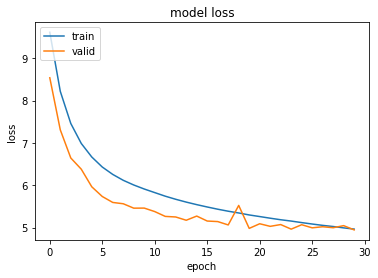

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [0]:

# model.load_weights('best_weights.hdf5')
model.save('model.h5')

In [0]:
pred = model.predict(X_test, batch_size=10000)

In [65]:
test["demand"] = pred.clip(0)
submission_final = test.pivot(index="id", columns="F", values="demand").reset_index()[submission.columns]
submission = submission[["id"]].merge(submission_final, how="left", on="id")
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.832368,0.756863,0.734746,0.740201,0.796867,0.882737,1.044703,0.710348,0.765450,0.777579,0.808767,0.947426,1.212560,0.907879,0.915701,0.829958,0.768981,0.792282,0.923666,1.050535,1.044166,0.853820,0.790577,0.788597,0.837376,0.891194,1.084629,1.119114
1,HOBBIES_1_002_CA_1_validation,0.345159,0.320429,0.317591,0.314961,0.329791,0.369994,0.381916,0.286592,0.281112,0.239698,0.267088,0.297604,0.317559,0.271434,0.272571,0.227692,0.252716,0.257025,0.254111,0.310546,0.325598,0.241203,0.230447,0.259037,0.249228,0.267081,0.305940,0.304488
2,HOBBIES_1_003_CA_1_validation,0.371155,0.354089,0.347609,0.353533,0.367252,0.406620,0.454412,0.289508,0.288926,0.246219,0.291292,0.298223,0.309569,0.253096,0.265559,0.214067,0.269377,0.314043,0.339630,0.368432,0.441109,0.407656,0.428672,0.437739,0.388165,0.423901,0.469760,0.476023
3,HOBBIES_1_004_CA_1_validation,1.817111,1.629071,1.578485,1.565416,1.866528,2.132736,2.474410,1.680255,1.692172,1.583424,1.556177,1.827054,2.539147,2.110204,1.927593,1.673735,1.646105,1.613513,1.790637,1.998657,2.445049,1.790044,1.607040,1.533915,1.558794,1.788638,2.644964,2.333215
4,HOBBIES_1_005_CA_1_validation,0.912695,0.832961,0.920651,1.019747,1.053493,1.319488,1.880512,1.130287,1.137448,1.016856,0.985975,1.164582,1.470109,1.047487,1.137678,1.000929,0.920182,0.938681,1.108994,1.245355,1.295572,0.943137,0.903889,0.890848,0.919890,1.022298,1.289122,1.550982


In [0]:
submission.to_csv("submission.csv", index=False)

1st Submission - Rank - 1196   and Score  0.62872